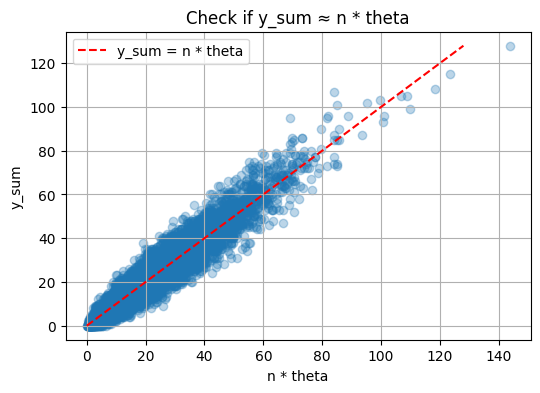

Epoch 0, Loss: 124.37531
Epoch 100, Loss: -70.46174
Epoch 200, Loss: -75.53571
Epoch 300, Loss: -75.96986
Epoch 400, Loss: -75.22815
Epoch 500, Loss: -75.10645
Epoch 600, Loss: -74.42381
Epoch 700, Loss: -75.19060
Epoch 800, Loss: -72.12601
Epoch 900, Loss: -74.15137


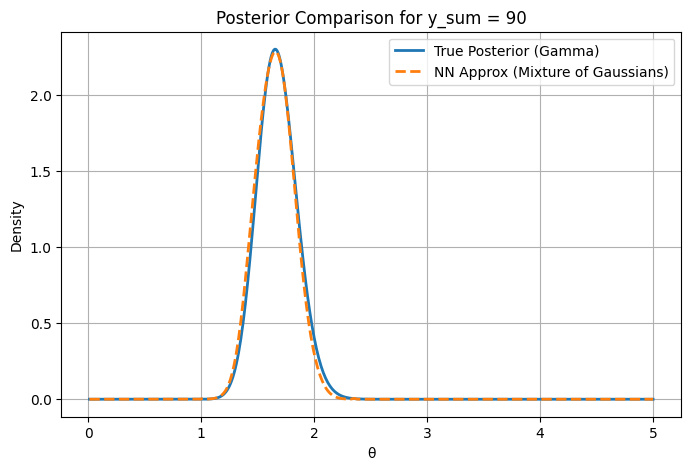

In [1]:
import random
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, ks_2samp, wasserstein_distance

# Set seed
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set prior parameters
alpha = 2
beta_prior = 5
M = 10000

# Simulate data
n = 50
df_final = pd.DataFrame()
theta_vec = np.random.gamma(shape=alpha, scale=1 / beta_prior, size=M)
y_sum_vec = [np.sum(np.random.poisson(lam=theta, size=n)) for theta in theta_vec]
df_final = pd.DataFrame({'theta': theta_vec, 'y_sum': y_sum_vec, 'n': n})

# Plot check: y_sum ~= n * theta
plt.figure(figsize=(6, 4))
plt.scatter(df_final['theta'] * df_final['n'], df_final['y_sum'], alpha=0.3)
plt.plot([0, max(df_final['y_sum'])], [0, max(df_final['y_sum'])], 'r--', label='y_sum = n * theta')
plt.xlabel("n * theta")
plt.ylabel("y_sum")
plt.title("Check if y_sum ≈ n * theta")
plt.legend()
plt.grid(True)
plt.show()

# Prepare data for training
unique_pairs = df_final[['y_sum', 'n']].drop_duplicates().reset_index(drop=True)
thetas = [
    df_final[(df_final['y_sum'] == row['y_sum']) & (df_final['n'] == row['n'])]['theta'].values
    for _, row in unique_pairs.iterrows()
]

# Model definition
class MixtureDensityNN(nn.Module):
    def __init__(self, K=8):
        super().__init__()
        self.K = K
        self.backbone = nn.Sequential(
            nn.Linear(2, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
        )
        self.logits_head = nn.Linear(16, K)
        self.mu_head = nn.Linear(16, K)
        self.log_var_head = nn.Linear(16, K)

    def forward(self, x):
        h = self.backbone(x)
        logits = self.logits_head(h)
        weights = torch.softmax(logits, dim=-1)
        mu = self.mu_head(h)
        log_var = self.log_var_head(h)
        return weights, mu, log_var


def mixture_log_likelihood(theta_vals, weights, mu, log_var):
    var = torch.exp(log_var)
    std = torch.sqrt(var)
    theta = theta_vals.expand(-1, mu.shape[1])
    log_probs = -0.5 * (log_var + np.log(2 * np.pi) + (theta - mu)**2 / var)
    log_weighted = torch.log(weights + 1e-8) + log_probs
    log_sum_exp = torch.logsumexp(log_weighted, dim=1)
    return -log_sum_exp.mean()

# Training
model = MixtureDensityNN(K=8)
optimizer = optim.Adam(model.parameters(), lr=0.01)
y_max = df_final['y_sum'].max()
n_max = df_final['n'].max()

for epoch in range(1000):
    model.train()
    total_loss = 0.0
    for (y_val, n_val), theta_arr in zip(unique_pairs.values, thetas):
        if len(theta_arr) < 2 or np.var(theta_arr) == 0:
            continue
        x_input = torch.tensor([[y_val / y_max, n_val / n_max]], dtype=torch.float32)
        weights, mu, log_var = model(x_input)
        theta_vals = torch.tensor(theta_arr, dtype=torch.float32).view(-1, 1)
        loss_i = mixture_log_likelihood(theta_vals, weights, mu, log_var)
        total_loss += loss_i

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss.item():.5f}")

# Evaluation on one test case
y_obs = 90
x_test = torch.tensor([[y_obs / y_max, n / n_max]], dtype=torch.float32)
with torch.no_grad():
    weights, mu, log_var = model(x_test)

# Mixture approximation
theta_range = np.linspace(0.01, 5.0, 500)
approx_pdf = np.zeros_like(theta_range)
K = weights.shape[1]
for k in range(K):
    pi_k = weights[0, k].item()
    mu_k = mu[0, k].item()
    std_k = np.sqrt(np.exp(log_var[0, k].item()))
    approx_pdf += pi_k * norm.pdf(theta_range, loc=mu_k, scale=std_k)

# True posterior
alpha_post = alpha + y_obs
beta_post = beta_prior + n
true_pdf = gamma.pdf(theta_range, a=alpha_post, scale=1 / beta_post)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(theta_range, true_pdf, label="True Posterior (Gamma)", lw=2)
plt.plot(theta_range, approx_pdf, label="NN Approx (Mixture of Gaussians)", lw=2, linestyle="--")
plt.title(f"Posterior Comparison for y_sum = {y_obs}")
plt.xlabel("θ")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

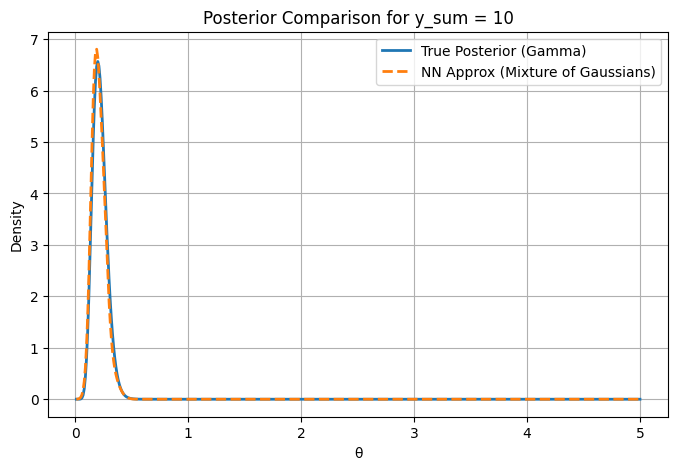

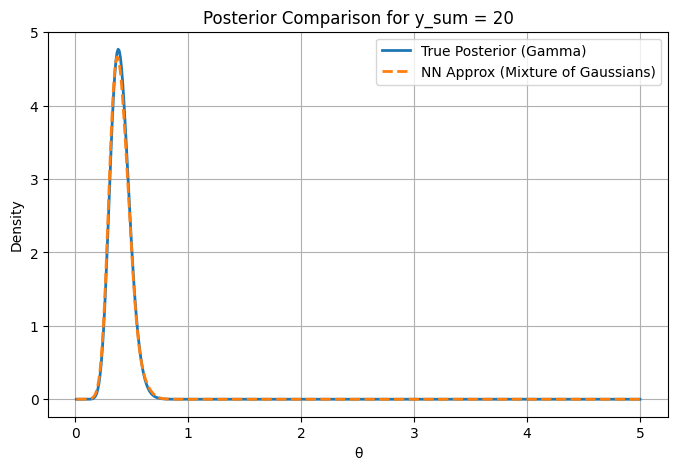

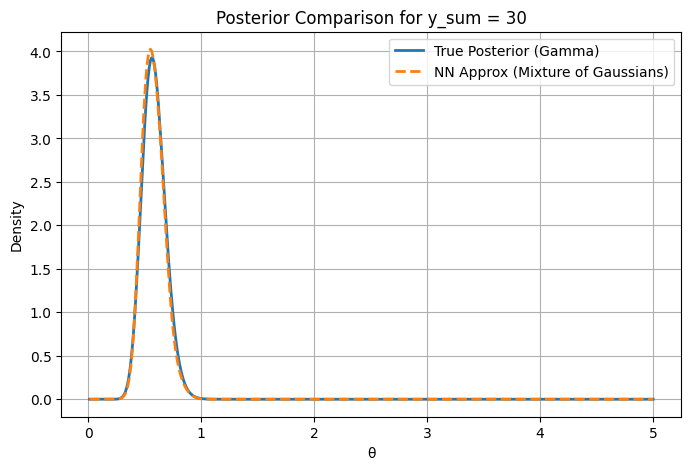

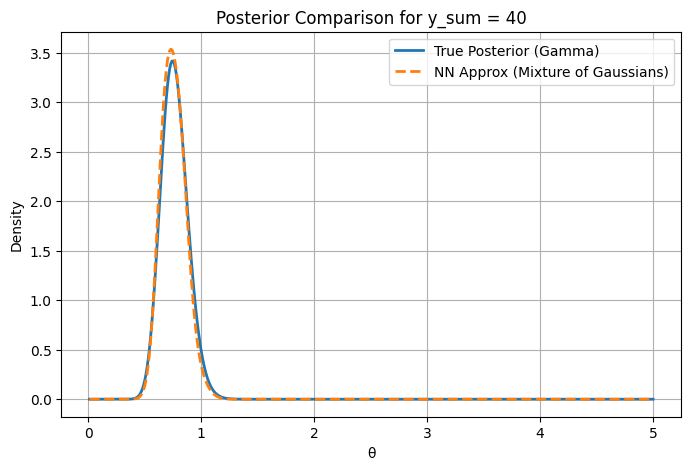

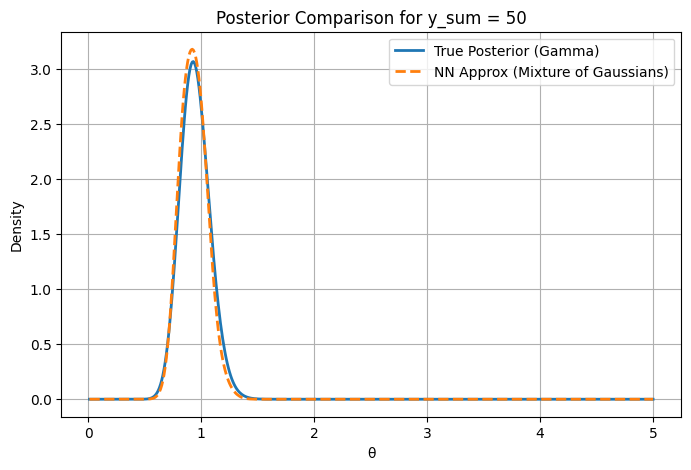

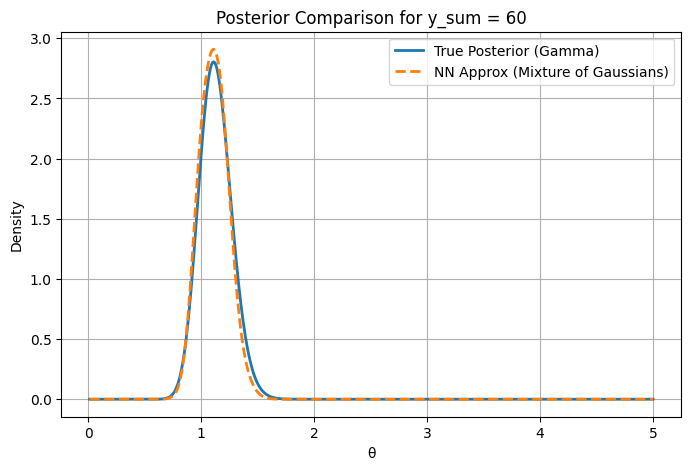

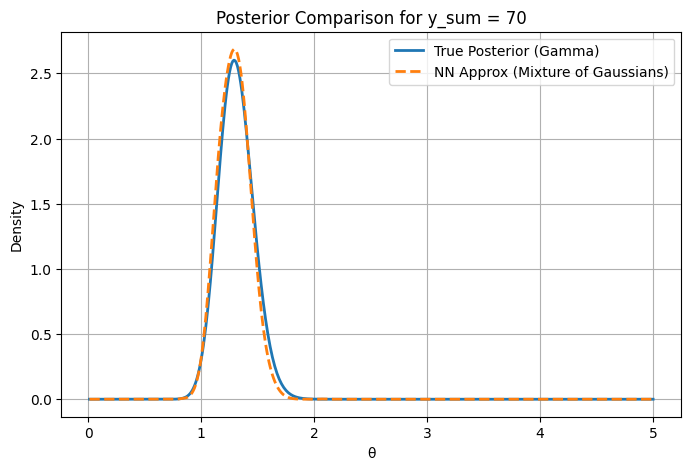

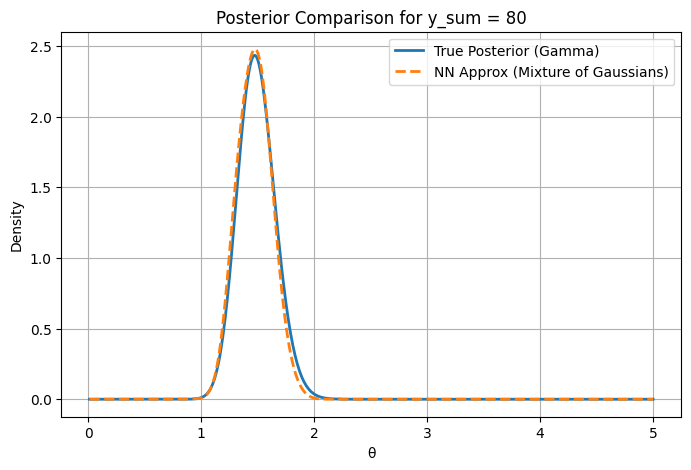

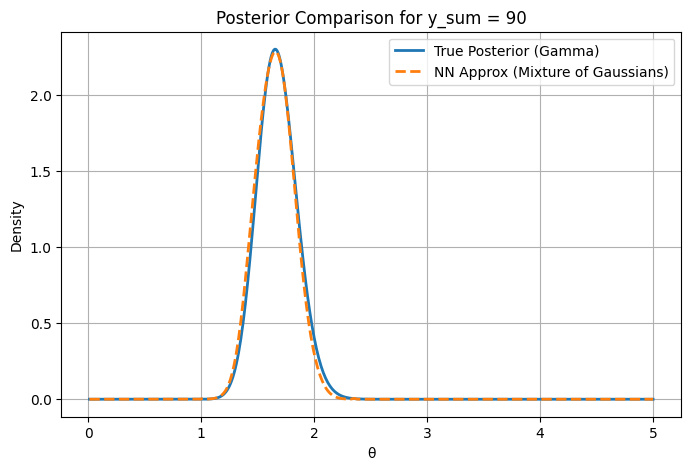

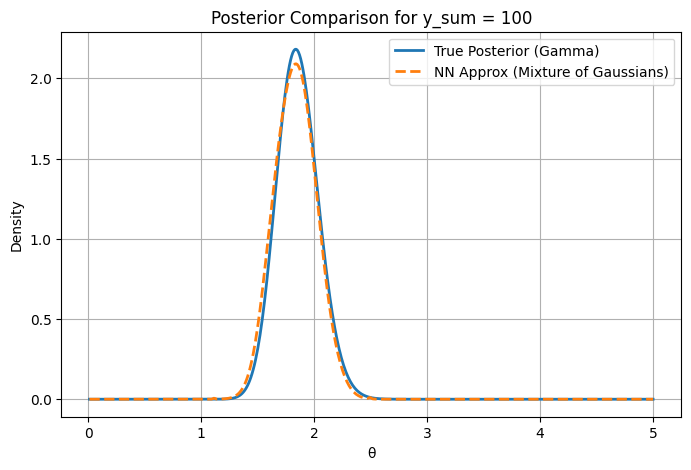

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma

n = 50

# 设置一组 y_obs 值
y_obs_list = list(range(10, 101, 10))

theta_range = np.linspace(0.01, 5.0, 500)

for y_obs in y_obs_list:
    # 归一化后输入模型
    x_test = torch.tensor([[y_obs / y_max, n / n_max]], dtype=torch.float32)
    with torch.no_grad():
        weights, mu, log_var = model(x_test)

    # 近似后验：混合高斯
    approx_pdf = np.zeros_like(theta_range)
    K = weights.shape[1]
    for k in range(K):
        pi_k = weights[0, k].item()
        mu_k = mu[0, k].item()
        std_k = np.sqrt(np.exp(log_var[0, k].item()))
        approx_pdf += pi_k * norm.pdf(theta_range, loc=mu_k, scale=std_k)

    # 真实后验（Gamma）
    alpha_post = alpha + y_obs
    beta_post = beta_prior + n
    true_pdf = gamma.pdf(theta_range, a=alpha_post, scale=1 / beta_post)

    # 绘图
    plt.figure(figsize=(8, 5))
    plt.plot(theta_range, true_pdf, label="True Posterior (Gamma)", lw=2)
    plt.plot(theta_range, approx_pdf, label="NN Approx (Mixture of Gaussians)", lw=2, linestyle="--")
    plt.title(f"Posterior Comparison for y_sum = {y_obs}")
    plt.xlabel("θ")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
